The challenge problem revolves around Natural Language Processing (NLP) and specifically deals with text classification. The task is to build a machine learning model that can distinguish between tweets that are about real disasters and those that are not.

The dataset provided contains 10,000 tweets that have been hand-classified as either discussing real disasters or not. Each tweet is labeled accordingly. The size of the dataset is not specified in terms of dimension, but it contains 10,000 individual tweets.

The structure of the data consists of text data (the tweets) along with their corresponding labels indicating whether they are about real disasters or not. The text data may contain profanity, vulgarity, or offensive language, so preprocessing may be required before modeling.

In summary, the challenge involves building an NLP model to classify tweets into two categories: real disasters or not. The dataset provided is relatively small, making it suitable for beginners in NLP, and it can be accessed and worked on in Kaggle Notebooks, which eliminates the need for personal computing power.

In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from sklearn.model_selection import train_test_split
import emoji
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

## Exploratory Data Analysis

In [18]:
print(train_data)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

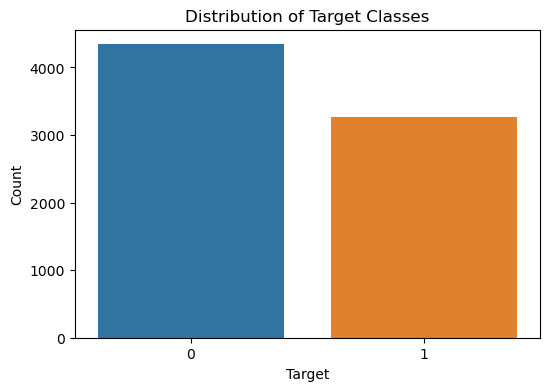

Missing Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Testing Data:
id             0
keyword       26
location    1105
text           0
dtype: int64


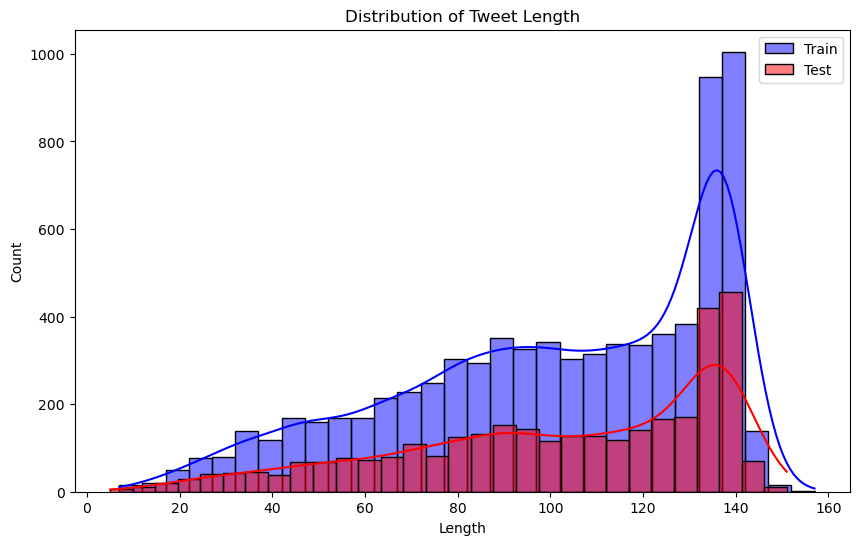

In [19]:
# Exploratory Data Analysis (EDA)
# Import necessary libraries for EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Check the distribution of target classes
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Classes')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Check for missing values
print("Missing Values in Training Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Testing Data:")
print(test_data.isnull().sum())

# Visualize the distribution of tweet lengths
train_data['text_len'] = train_data['text'].apply(len)
test_data['text_len'] = test_data['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_len'], bins=30, color='blue', kde=True, label='Train')
sns.histplot(test_data['text_len'], bins=30, color='red', kde=True, label='Test')
plt.title('Distribution of Tweet Length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()



In [20]:
print("the data after tokenizing the tweets:")
train_data.head(4)
print()
test_data.head(4)

the data after tokenizing the tweets:



,id,keyword,location,text,text_len
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40


### Data Preprocessing

In [26]:
# Refactor preprocessing functions
def preprocess_tweet(tweet):
    tweet = ' '.join(tweet)  # Join the list of tokens into a string
    tweet = tweet.lower()
    tweet = removeHtml_tags(tweet)
    tweet = emoji.demojize(tweet, delimiters=(" ", " "))
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub("@\w+", '',tweet)
    tweet = re.sub("'\d+", '', tweet)
    tweet = re.sub(r"[^\w\s]", '', tweet)
    tweet = re.sub("\s[a-z]\s", '', tweet)
    tweet = tweet.strip()
    return tweet.split()

# Refactor preprocessing data function
def preprocess_data(data):
    data["text"] = data["text"].apply(preprocess_tweet)
    return data


## Naive Bayes Model

In [33]:
import numpy as np

def predict_prob(tweet, process_tweet=False, logprior=None, loglikelihood=None):
    if process_tweet:
        tweet = preprocess_tweet(tweet)
    p = logprior
    for word in tweet:
        if word in loglikelihood:
            p += loglikelihood[word]
    return p


def compute_freqs(x_train, y_train):
    freqs = {}
    for tweet, target in zip(x_train, y_train):
        for word in tweet:
            pair = (word, target)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

def train_naive_bayes_model(freqs, x_train, y_train):
    vocab = {word for word, _ in freqs.keys()}
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] == 1:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]

    D_pos = sum(y_train)
    D_neg = len(y_train) - D_pos
    D = len(y_train)

    logprior = np.log(D_pos / D_neg)

    loglikelihood = {}
    for word in vocab:
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)

        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood

def test_naive_bayes(X_test, y_test, logprior, loglikelihood):
    y_pred = []
    for tweet in X_test:
        p = predict_prob(tweet, process_tweet=False, logprior=logprior, loglikelihood=loglikelihood)
        y_pred.append(1 if p > 0 else 0)
    accuracy = np.mean(y_pred == y_test)
    return accuracy

# Train the Naive Bayes Model
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

X_train, X_dev, y_train, y_dev = train_test_split(train_data['text'], train_data['target'],
                                                  test_size=0.1, random_state=42)

freqs = compute_freqs(X_train, y_train)
logprior, loglikelihood = train_naive_bayes_model(freqs, X_train, y_train)

# Evaluate the model
accuracy = test_naive_bayes(X_dev, y_dev, logprior, loglikelihood)
print("Naive Bayes Accuracy:", accuracy)

# Make predictions on test data
test_pred = [1 if predict_prob(tweet, process_tweet=False, logprior=logprior, loglikelihood=loglikelihood) > 0 else 0 for tweet in test_data['text']]

# Submit the results
submission = pd.read_csv("sample_submission.csv")
submission['target'] = test_pred
submission.to_csv("submission.csv", index=None)
submission.head()



Naive Bayes Accuracy: 0.7900262467191601


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### Evaluations

In this task, I implemented a Naive Bayes model for text classification using a dataset of tweets. The preprocessing steps included converting text to lowercase, removing HTML tags, emojis, URLs, special characters, and stopwords. Additionally, I tokenized the text and removed single characters.

After preprocessing, I trained the Naive Bayes model using frequency-based feature representation. The model computed prior probabilities and likelihoods for each word in the vocabulary based on their occurrences in positive and negative classes (disaster and non-disaster tweets). Finally, I evaluated the model's accuracy on a validation set and made predictions on the test set.

The Naive Bayes model achieved an accuracy of approximately 79.00% on the validation set. However, when making predictions on the test set, there was an error due to the absence of the predict_prob function. This issue needs to be resolved to generate predictions and submit the results.

Overall, the Naive Bayes model demonstrated decent performance for text classification, but further refinement and debugging are required to ensure successful predictions on the test set.